# Can You Catch Them All?
##### Your Aspiring Trainer: Anna Vu
<br>

Embark on a journey to create a multi-class machine learning algorithm that will predict level of difficulty for catching a particular Pokemon!

Grab your starter, and let's go!

# Planning

---

I am going to need a dataset with all existing Pokemons, and a catch rate column to use as a target. <br>

My selected dataset:

https://www.kaggle.com/mariotormo/complete-pokemon-dataset-updated-090420

 - Target: Catch rates/simplified catch rates
 - Goals: To be able to predict classified catch rates based on certain features
 - Initial Thoughts/Hypothesis: I believe ability type and numbers will be able to predict catch rates, along with other things like their stats (attack, defense, hp.) May also depend on whether they're normal or legendary. 
 - Trello: https://trello.com/b/pk8AN3Ru/individual-project)

There are a lot of unique catch rates, so I'm going to have to figure out some bins to put them into. 
I'll make 5 groups where: <br>

 - 1 is the lowest catch rate group (the extremely difficult)
 - 2 is hard
 - 3 is medium
 - 4 is easy
 - 5 is very easy

<br>
<br>

# Acquire
---

In this stage, I will be bringing in the pokdex.csv.
First, I'm going to import libraries and other functions I'm going to be using

In [1]:
#importing the goods
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from wrangle import (get_pokemon, prepare_pokemon, train_validate_test, get_object_cols, get_numeric_X_cols, ready_for_battle,
pokemon_split, split_X_y, standard_scale_data)

from explore import (get_pokemon_heatmap, explore_univariate, histplot, count_and_histplots, scatterplot, create_cluster,
create_scatter_plot,plot_categorical_and_continuous_vars, categorical_bar, make_cluster, inertia, chi2test, anova_test, selectkbest)

from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from scipy.stats import f_oneway

In [2]:
#turn pokedex.csv into a pandas dataframe
df = get_pokemon()

In [3]:
#check for nulls and missing values
df.isna().sum()

Unnamed: 0            0
pokedex_number        0
name                  0
german_name           0
japanese_name         0
generation            0
status                0
species               0
type_number           0
type_1                0
type_2              492
height_m              0
weight_kg             1
abilities_number      0
ability_1             3
ability_2           529
ability_hidden      232
total_points          0
hp                    0
attack                0
defense               0
sp_attack             0
sp_defense            0
speed                 0
catch_rate           18
base_friendship     115
base_experience     120
growth_rate           1
egg_type_number       0
egg_type_1            3
egg_type_2          760
percentage_male     173
egg_cycles            1
against_normal        0
against_fire          0
against_water         0
against_electric      0
against_grass         0
against_ice           0
against_fight         0
against_poison        0
against_ground  

Acquire Takeaways:
 - There's some columns we should drop
 - Missing values to address and take care of
 - Initial exploration (in previous notebooks) show that there's some values that simply don't belong.
 - We should also enumerate some of the object columns, and create our target feature from catch_rates

<br>
<br>

# Prepare
---

I made a ready_for_battle function that cleans up the pokedex.csv. Using it will fill in missing values, adjust data that may have been wrongly inputted, create our target variable, create new features, create new numeric columns from object ones, and drop columns we will not need.

We will also be splitting and scaling our data.

In [4]:
#use ready_for_battle on our pokedex dataframe
df = ready_for_battle(df)

In [5]:
#assure there are no nulls
df.isna().sum().sum()

0

In [6]:
#sneak peak of the data
df.sample(5)

,pokedex_number,name,generation,status,species,type_number,type_1,type_2,height_m,weight_kg,...,against_fairy,is_genderless,ability_1_num,ability_2_num,ability_hidden_num,status_num,primary_num,secondary_num,growth_num,simplified_catch_rate
242,196,Espeon,2,Normal,Sun Pokémon,1,Psychic,None,0.9,26.5,...,1.0,0,25.0,0.0,53.0,0.0,4.0,0.0,0.0,2
778,665,Spewpa,6,Normal,Scatterdust Pokémon,1,Bug,None,0.3,8.4,...,1.0,0,18.0,0.0,33.0,0.0,3.0,0.0,0.0,3
65,51,Dugtrio,1,Normal,Mole Pokémon,1,Ground,None,0.7,33.3,...,1.0,0,24.0,58.0,9.0,0.0,11.0,0.0,0.0,2
621,524,Roggenrola,5,Normal,Mantle Pokémon,1,Rock,None,0.4,18.0,...,1.0,0,9.0,63.0,9.0,0.0,7.0,0.0,2.0,5
299,247,Pupitar,2,Normal,Hard Shell Pokémon,2,Rock,Ground,1.2,152.0,...,1.0,0,18.0,0.0,0.0,0.0,7.0,4.0,1.0,2


In [7]:
#split into train, validate, and test sets (stratifies by simplified_catch_rate)
train, validate, test = pokemon_split(df)

In [8]:
#check their shapes, looks good!
train.shape, validate.shape, test.shape

((585, 56), (251, 56), (209, 56))

In [9]:
#split into X sets and y sets
X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train, validate, test, 'simplified_catch_rate')

In [10]:
#get our object columns
obj_cols = get_object_cols(df)

In [11]:
#get our numeric columns
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [12]:
#scale with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols], X_validate[num_cols], X_test[num_cols])

Prepare Takeaways:
 - Our data is now clean and ready to use
 - Split into train, validate, and test sets
 <br>
 <br>

# Explore
---

<AxesSubplot:title={'center':'Features Correlated with Catch Rates'}>

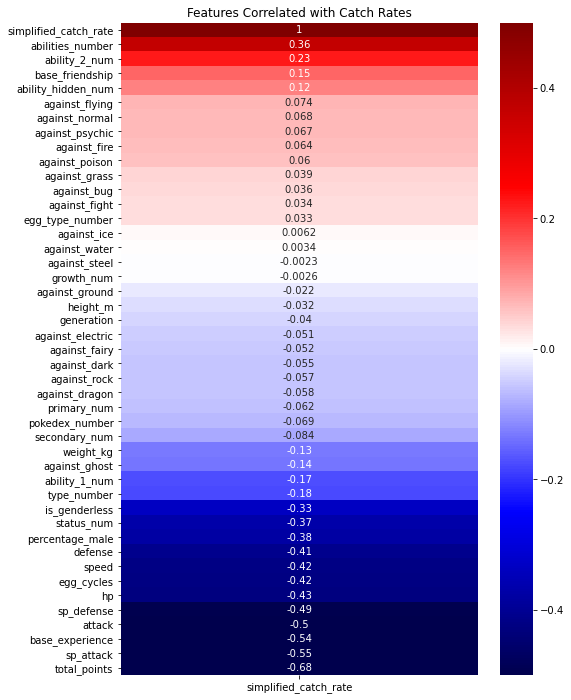

In [13]:
#a heatmap with features and how much they correlate to simplified_catch_rate
get_pokemon_heatmap(train)

In [14]:
#features, continuous features, and categorical features that I find could be most relevant to catch rate. 
all_stuff = train[['total_points','sp_attack','base_experience','attack','hp','sp_defense','egg_cycles','percentage_male','is_genderless','abilities_number','growth_num','status_num','weight_kg','height_m']]
cont_feats = train[['total_points','hp','attack','defense','sp_attack','sp_defense','speed']]
categorical_features = train[['is_genderless','abilities_number','percentage_male','egg_cycles','status_num','growth_num']]

#### Univariate Exploration

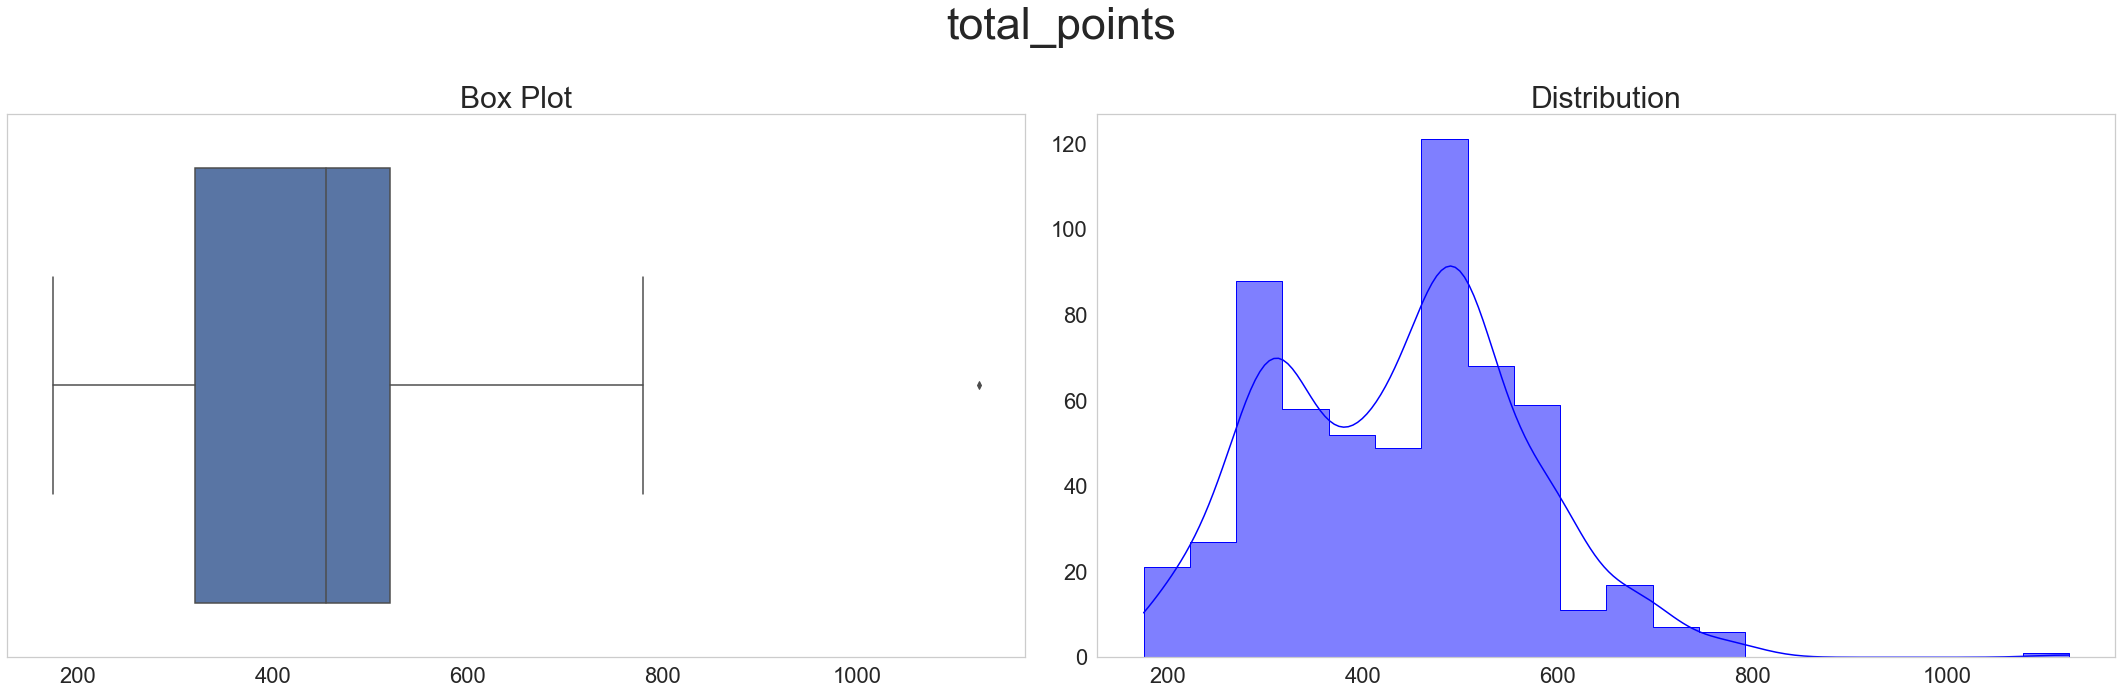

Summary Statistics for total_points
count     585.000000
mean      438.774359
std       129.332892
min       175.000000
25%       320.000000
50%       455.000000
75%       520.000000
max      1125.000000
Name: total_points, dtype: float64


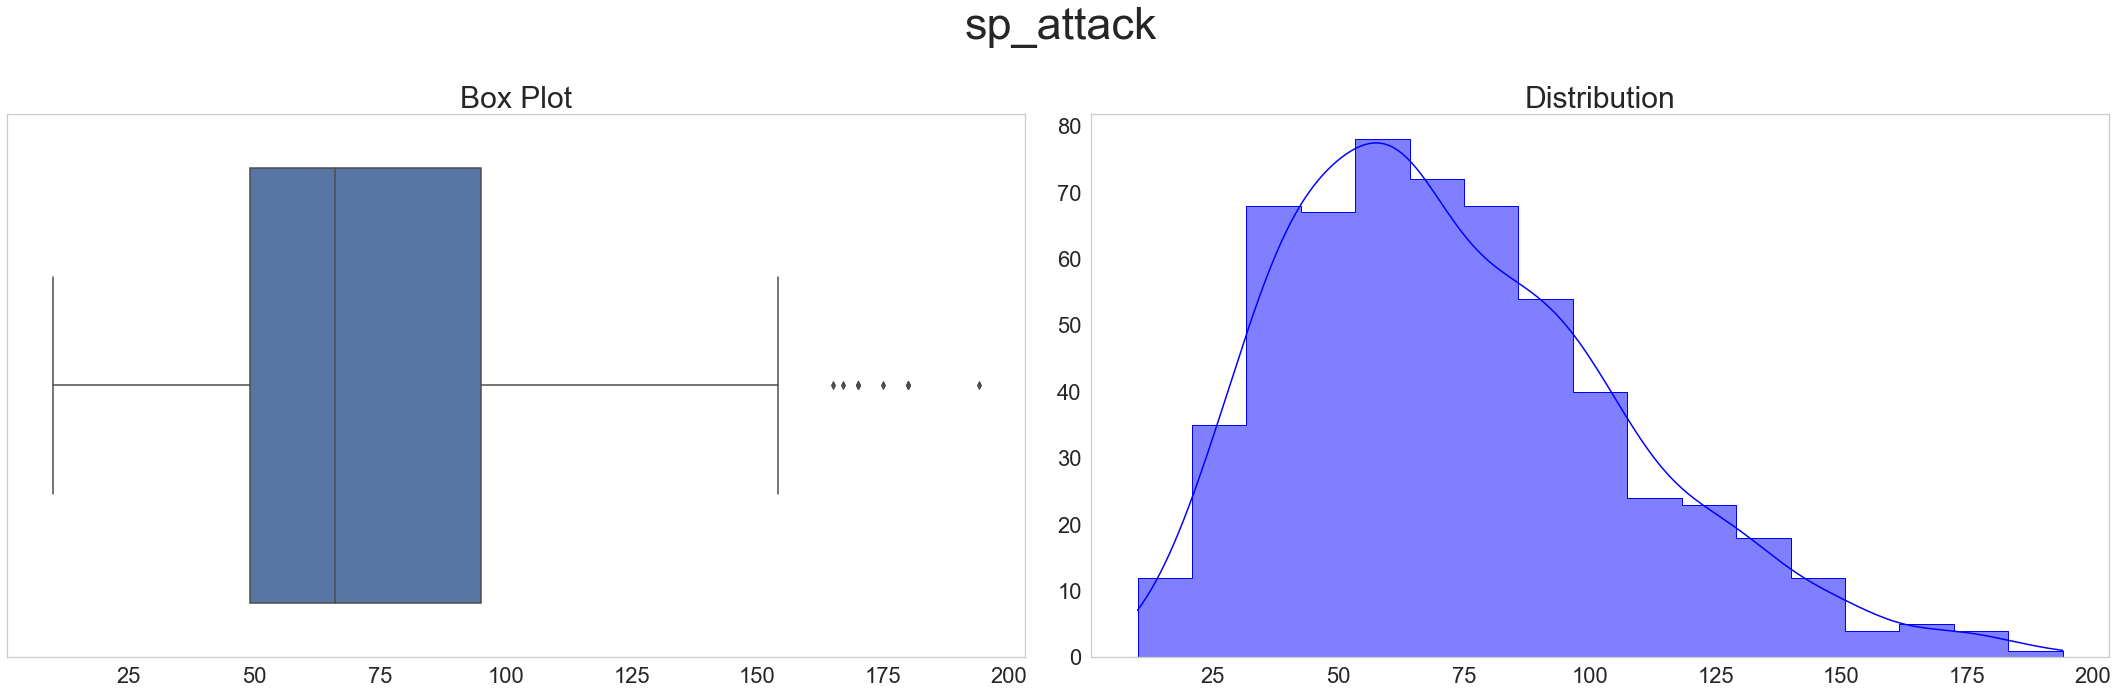

Summary Statistics for sp_attack
count    585.000000
mean      73.490598
std       33.751920
min       10.000000
25%       49.000000
50%       66.000000
75%       95.000000
max      194.000000
Name: sp_attack, dtype: float64


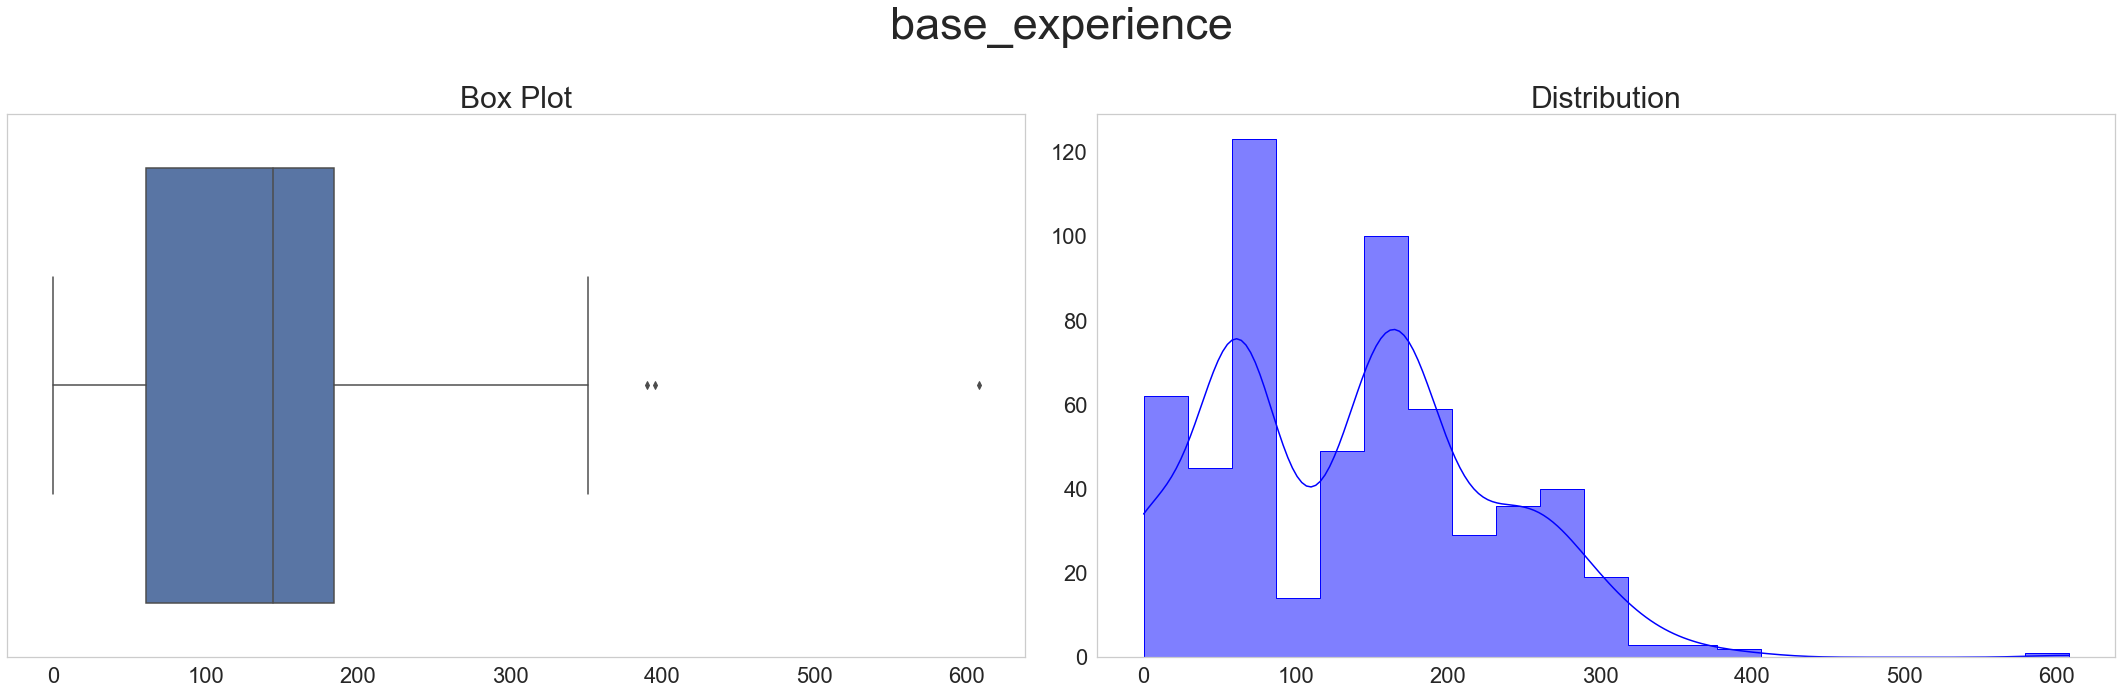

Summary Statistics for base_experience
count    585.000000
mean     137.270085
std       91.200830
min        0.000000
25%       61.000000
50%      144.000000
75%      184.000000
max      608.000000
Name: base_experience, dtype: float64


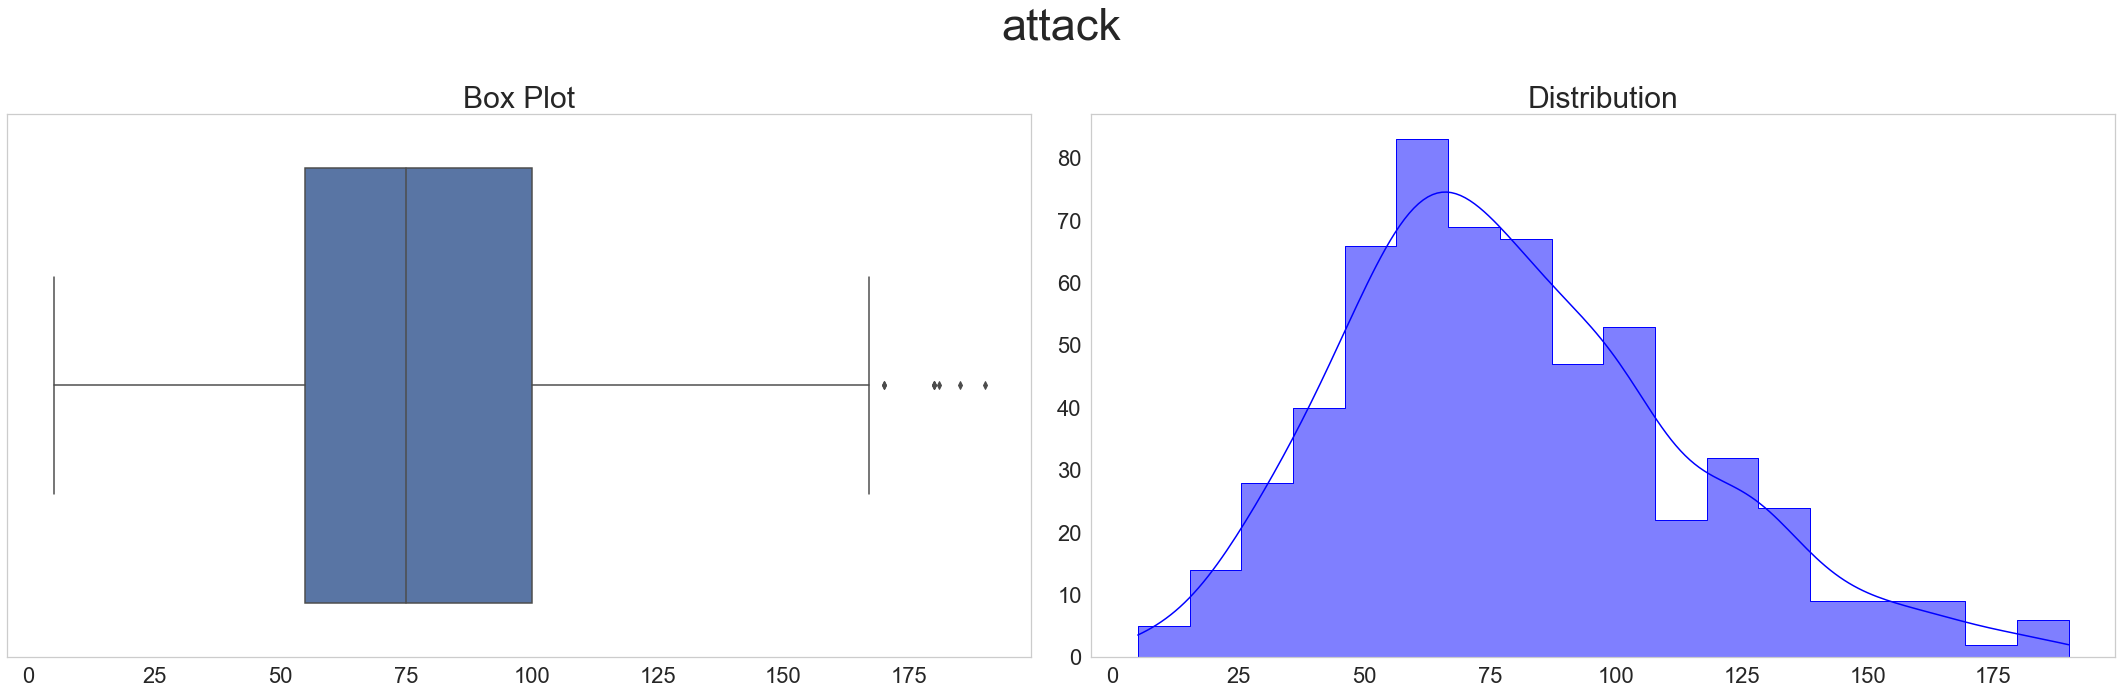

Summary Statistics for attack
count    585.000000
mean      79.993162
std       34.141426
min        5.000000
25%       55.000000
50%       75.000000
75%      100.000000
max      190.000000
Name: attack, dtype: float64


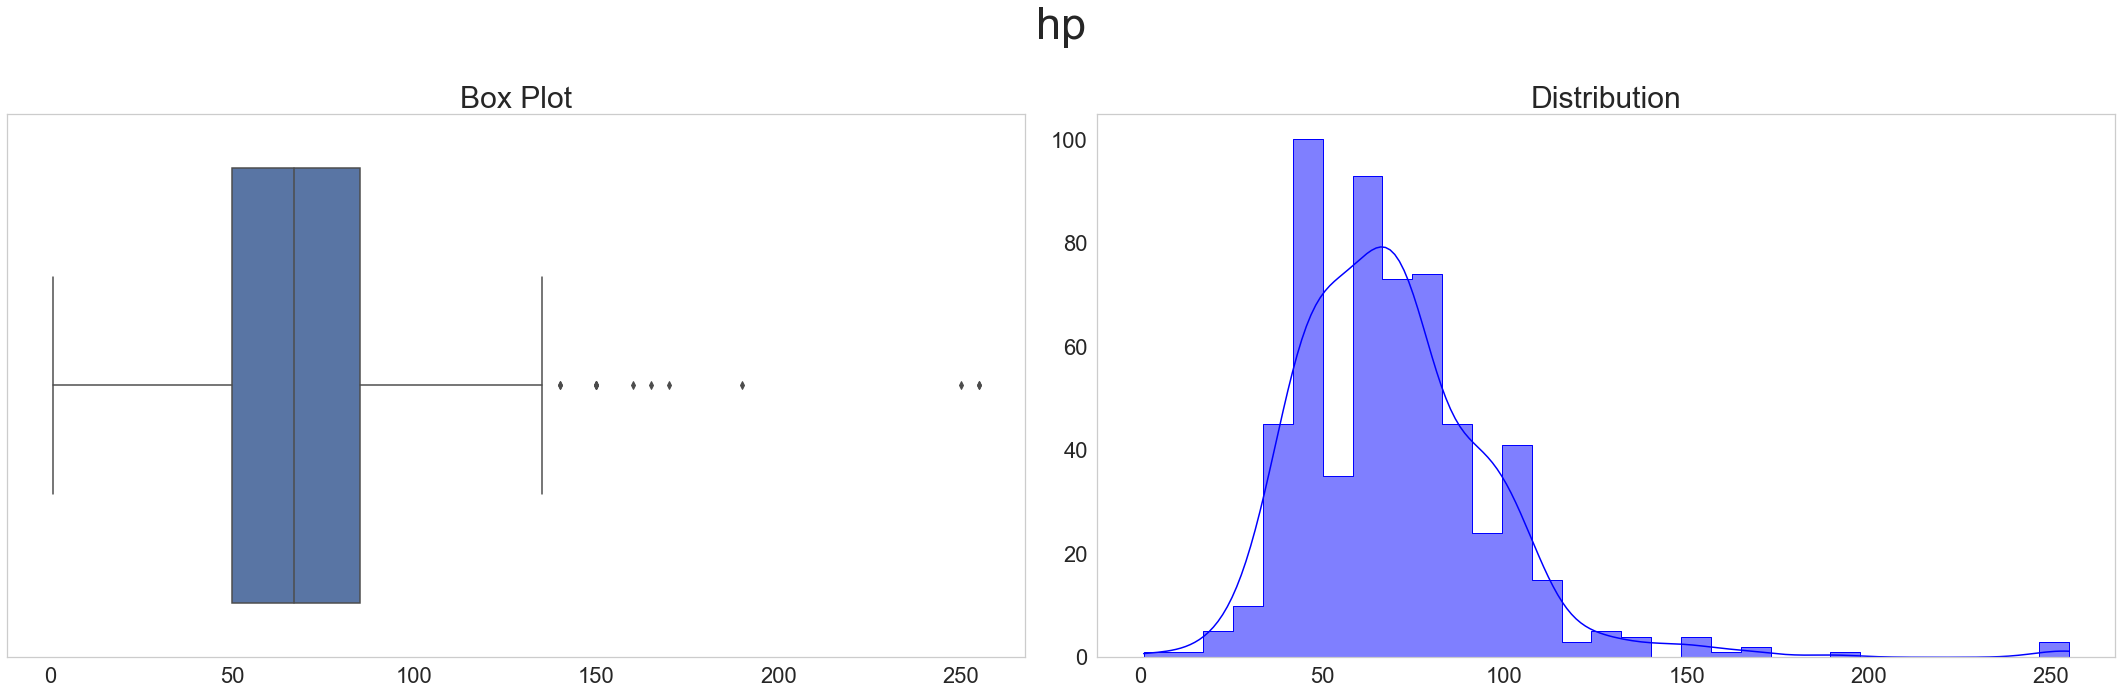

Summary Statistics for hp
count    585.000000
mean      70.234188
std       28.019896
min        1.000000
25%       50.000000
50%       67.000000
75%       85.000000
max      255.000000
Name: hp, dtype: float64


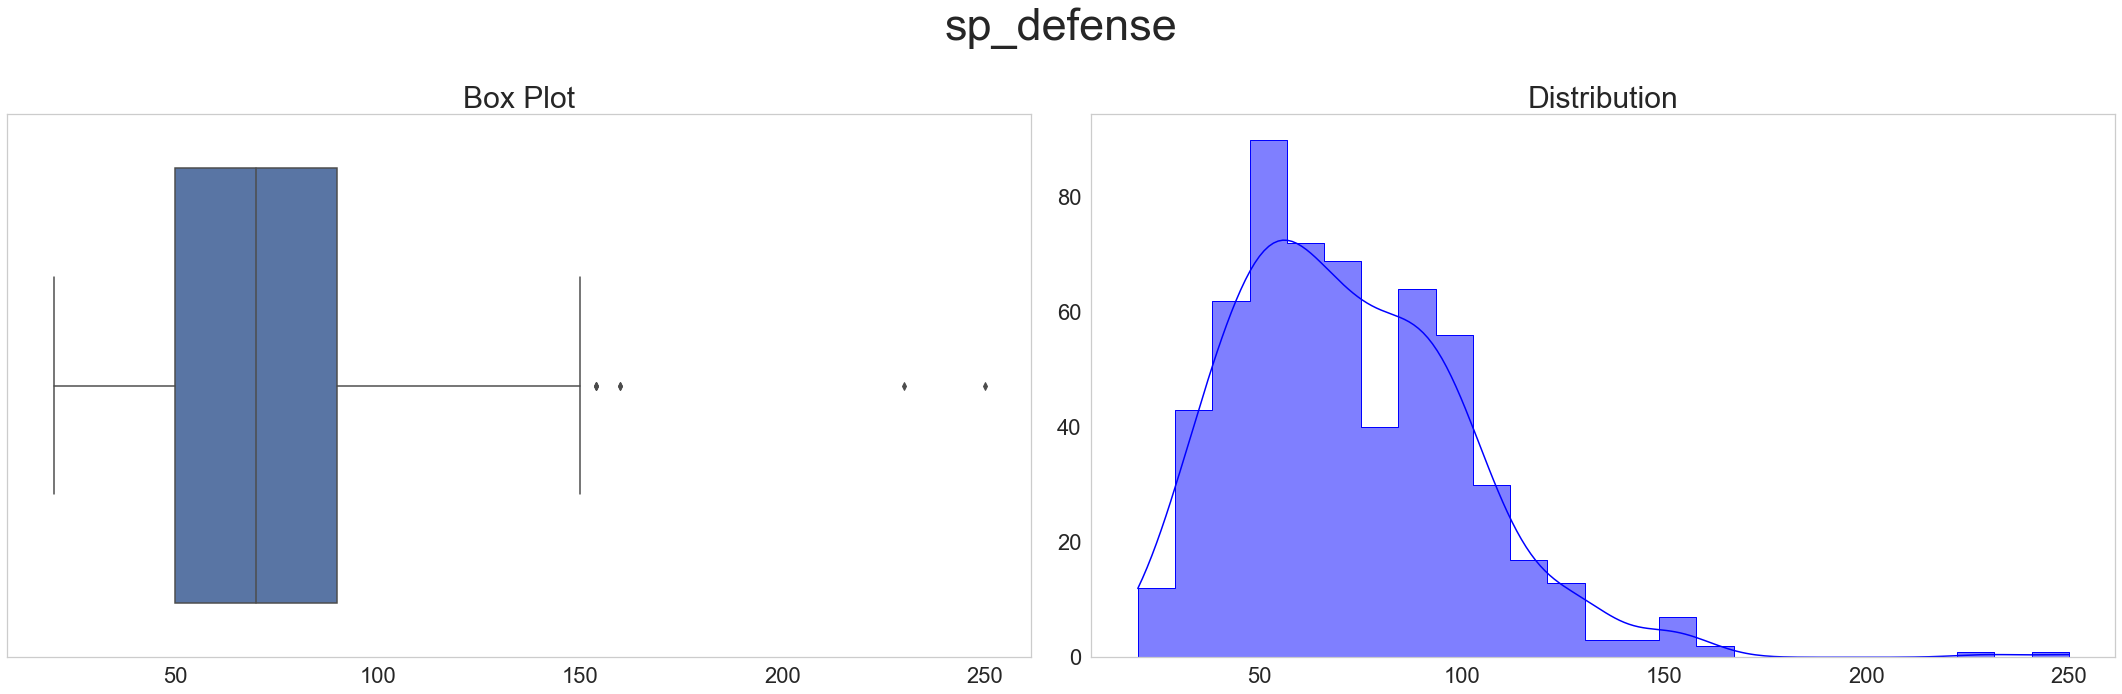

Summary Statistics for sp_defense
count    585.000000
mean      72.377778
std       29.505848
min       20.000000
25%       50.000000
50%       70.000000
75%       90.000000
max      250.000000
Name: sp_defense, dtype: float64


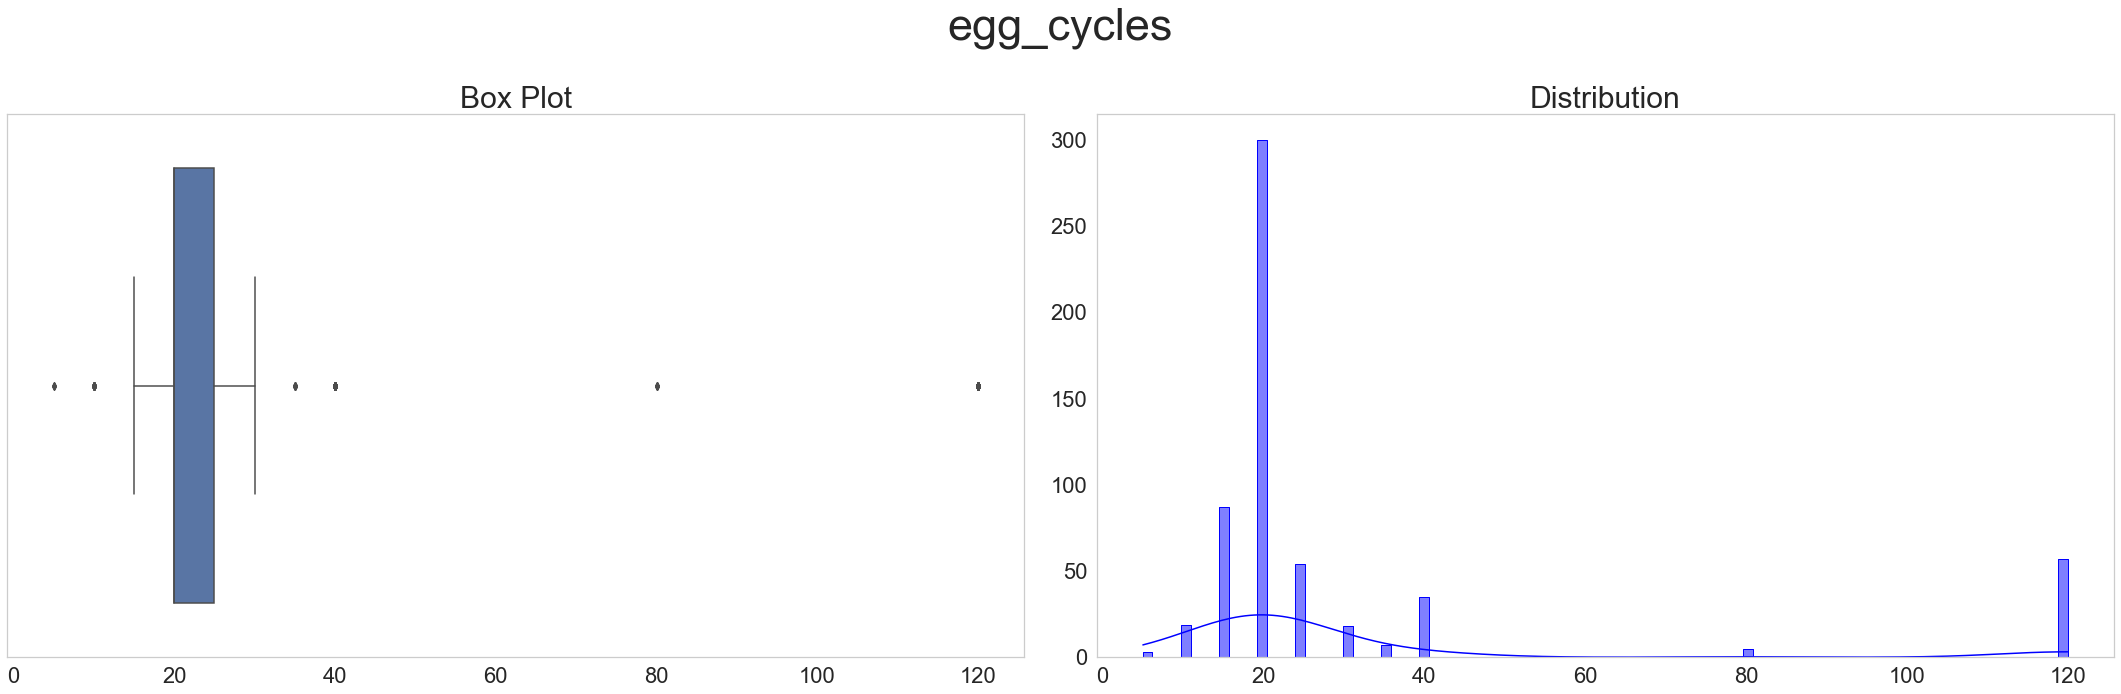

Summary Statistics for egg_cycles
count    585.000000
mean      31.256410
std       30.333521
min        5.000000
25%       20.000000
50%       20.000000
75%       25.000000
max      120.000000
Name: egg_cycles, dtype: float64


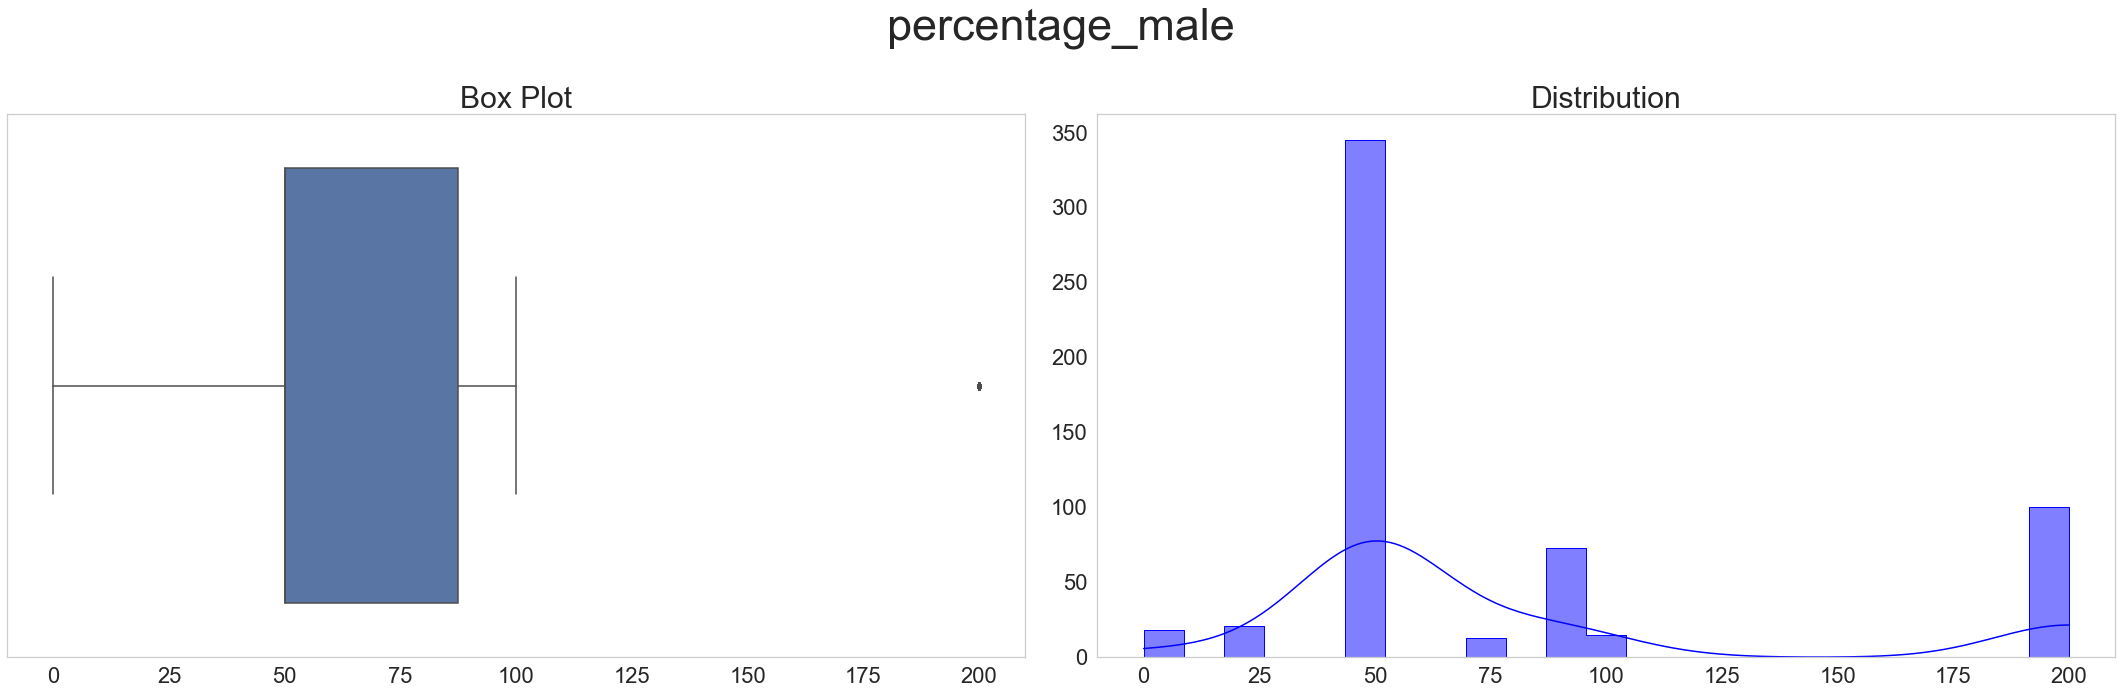

Summary Statistics for percentage_male
count    585.000000
mean      79.722222
std       57.630304
min        0.000000
25%       50.000000
50%       50.000000
75%       87.500000
max      200.000000
Name: percentage_male, dtype: float64


In [ ]:
#box plots and histograms of the features, with basic summary statistics for each.
for i in all_stuff:
    explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

<br>

Boxplots and Distribution Takeaways:
 - Battle stats are skewed right
 - Size is skewed right
 - Total points is bimodal
 - Most Pokemon have 3 abilities
 <br>
 <br>

Let's look at the histograms, but with their catch rates

In [ ]:
#distributions with simplified_catch_rate as the hue
for i in all_stuff:
    histplot(train, i, 'simplified_catch_rate')

In [ ]:
#let's look at count plots for some features, starting with our target. This function will also print a frequency table.
categorical_bar(train, 'simplified_catch_rate')

In [ ]:
categorical_bar(train, 'is_genderless')

In [ ]:
plt.figure(figsize=(12,5))
categorical_bar(train, 'percentage_male')

In [ ]:
categorical_bar(train, 'abilities_number')

In [ ]:
plt.figure(figsize=(12,5))
categorical_bar(train, 'egg_cycles')

In [ ]:
plt.figure(figsize=(12,5))
categorical_bar(train, 'status')

In [ ]:
plt.figure(figsize=(25,8))
categorical_bar(train, 'type_1')

In [ ]:
plt.figure(figsize=(25,8))
categorical_bar(train, 'type_2')

Takeaways: 
 - Most Pokemon tend to have lower levels of stats, and egg cycles (skewed right)
 - Higher catch rates tend to have lower levels of stats, and are not genderless
 - Weight and height are skewed right 
 - Category 2 (hard) is the most abundant type of Pokemon
 - Most Pokemon do not have a second ability
 - Our train data has more water Pokemon? I don't know if that's true for all of Pokemon...
 <br>
 <br>

#### Bivariate Exploration

Further diving into exploration. We're going to look at the features with respect to our target.

In [ ]:
for col in all_stuff:
    scatterplot(train, 'simplified_catch_rate', col)

Visual Takeaways:
  - Pokemon with lower catch rates tend to have higher total_points, hp, defense, and attack. They also tend to be bigger in size (with height and weight) although there's not much of a difference. 
  - Growth rate and number of abilities seems uniform throughout all difficulties.
  - Status number seems to have a really large affect their catch rate

<br>

#### Stats Testing

Let's run some statistical testing. Using chi^2 testing for categorical features to test for independence. alpha level is 0.05.

Null hypothesis: selected feature and simplified catch rate are independent.

Alternative hypothesis: selected feature and simplified catch rate are not independent

In [ ]:
for i in categorical_features:
    chi2test(train, i, "simplified_catch_rate")
    print('\n')

<br>
<br>
Let's run ANOVA testing on our continuous variables with respect to our target, simplified catch rates. alpha is 0.05

Null hypothesis: two or more groups have the same population mean

Alternative hypothesis: two or more groups do not have the same population mean. 

In [ ]:
for i in cont_feats:
    anova_test(train, i)
    print('\n')

Takeaways:
   - Seems that all of the features to have an affect on a Pokemon's catchability. Some features more less than others, but all siginificant with an alpha of 0.05.
   - We rejected all the null hypothesis in our chi^2 and ANOVA tests, proceed with the alternative

<br>

#### Multivariate Exploration
How do our non-target features interact with each other?

In [ ]:
plot_categorical_and_continuous_vars(train, 'is_genderless', 'total_points')

is_genderless vs. total_points:
 - Pokemon that are genderless tend to have a wider range, as well as higher total points.

In [ ]:
plot_categorical_and_continuous_vars(train, 'abilities_number', 'total_points')

abilities_number vs. total_points:
 - Easier Pokemon tend to have more than 1 ability.
 - Harder Pokemon tend to have just 1 ability 

In [ ]:
plot_categorical_and_continuous_vars(train, 'status_num', 'total_points')

status_num and total_points:
 - 0 status_num are the normal Pokemon
 - Harder Pokemon tend to be legendary, sub-legendary, or of mythical status. 

In [ ]:
#looking at my continuous variables with each other
scatterplot(train,'attack','total_points')

In [ ]:
scatterplot(train, 'defense','total_points')

In [ ]:
scatterplot(train, 'hp','total_points')

In [ ]:
scatterplot(train, 'attack','sp_attack')

Other Exploration Takeaways: 
   - A number of features such as total_points, the stat features, status number, and their gender percentage are strongly correlated with their catch rate. However, with our visuals, we can see there is also a lot of overlap and diversity in Pokemon.

In [ ]:
#using Select K Best for 10 features to use
new_kbest = selectkbest(X_train_scaled, y_train, 10)

<br>

# Modeling

Let's get down to classify. I will be using  decision tree, random forest, logistic regression, and KNN models. 

In [ ]:
def get_metrics(clf):
    '''
    get_metrics takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    X_train, y_train = train[x_col], train[y_col]

    X_validate, y_validate = validate[x_col], validate[y_col]

    X_test, y_test = test[x_col], validate[y_col]
    
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [ ]:
#our selected features
x_col = new_kbest
y_col='simplified_catch_rate'

In [ ]:
#just to see our selected features
new_kbest

In [ ]:
#using only our features
X_train, y_train = train[new_kbest], train[y_col]

X_validate, y_validate = validate[new_kbest], validate[y_col]

X_test, y_test = test[new_kbest], test[y_col]

<br>

#### Baseline

In [ ]:
#what should our baseline prediction be?
y_train.value_counts()

In [ ]:
#Category 2 (hard) is the most common, so that will be our prediction
train['baseline_prediction'] = 2
baseline_score = round(accuracy_score(train.simplified_catch_rate, train.baseline_prediction),2)
print(f'Our baseline score is {baseline_score}')

<br>
<br>
I'm going to emphasize overall precision, because I want to know how good my predictions are.

<br>

#### Decision Tree

In [ ]:
tree = DecisionTreeClassifier(max_leaf_nodes=12, max_depth=5)
tree.fit(X_train,y_train)
print(f'training score: {tree.score(X_train, y_train):.2%}')
print(f'validate score: {tree.score(X_validate, y_validate):.2%}')
y_pred = tree.predict(X_train)
get_metrics(tree)

In [ ]:
#visualize our decision tree
plt.figure(figsize=(16,9))
plot_tree(tree)
plt.show()

print(classification_report(y_train, y_pred))

In [ ]:
#decision tree scores
tree_precision = round(sklearn.metrics.precision_score(y_train, y_pred, average='macro'),2)
tree_recall = round(sklearn.metrics.recall_score(y_train, y_pred, average='macro'),2)
print('Scores for Decision Tree!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {tree_precision}')
print(f'recall score is {tree_recall}')

<br>

#### Random Forest

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
print(f'training score: {rf.score(X_train, y_train):.2%}')
print(f'validate score: {rf.score(X_validate, y_validate):.2%}')
get_metrics(rf)

In [ ]:
print('Scores for Random Forest!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0,average="macro"),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0, average="macro"),2)}')

<br>

#### Logistic Regression

In [ ]:
logit = LogisticRegression(C= 10, random_state =123)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print(f'training score: {logit.score(X_train, y_train):.2%}')
print(f'validate score: {logit.score(X_validate, y_validate):.2%}')
get_metrics(logit)

In [ ]:
print('Scores for Logistic Regression!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0,average="macro"),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0, average="macro"),2)}')

<br>

#### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print(f'training score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')
get_metrics(knn)

In [ ]:
print('Scores for KNN!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0, average="macro"),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0, average="macro"),2)}')

<br>
<br>

## Test

Precision, recall and accuracy were about the same between decision tree and KNN.

I'm going to use my decision tree model. It performed better than my KNN model on precision. 


In [ ]:
actual_test = y_test
predicted_test = tree.predict(X_test)
print(classification_report(actual_test, predicted_test))
print(f'Baseline score is {baseline_score*100}%')
print(f'training score: {tree.score(X_train, y_train):.2%}')
print(f'validate score: {tree.score(X_validate, y_validate):.2%}')
print(f'test score: {tree.score(X_test, y_test):.2%}')

<br>
<br>

In [ ]:
proba_test = tree.predict_proba(X_test)
proba_df = pd.DataFrame(proba_test, columns=tree.classes_.tolist())
reset_test = test.reset_index()
test_proba_df = pd.concat([reset_test, proba_df], axis=1)

test_proba_df['predicted'] = predicted_test
test_proba_df.head()

In [ ]:
print('                          Actual Simplified Catch Rates and Predicted')
histplot(test_proba_df, 'simplified_catch_rate' , 'predicted')

# Conclusion and Next Steps:
 - My decision tree model predicted on our unseen data with 71.29% accuracy.
 - It does pretty well predicting if a Pokemon is hard or extremely hard to catch
 - It doesn't do well differentiating between groups 4 and 5.
 
 With more time, I would like to further explore and look at the differences between Pokemon with a simplified catch rate of 4, and a simplified catch rate of 5. If there's not much, maybe I can combine them next time into a generic "easy" category.
 
Better to come overprepared for an easy battle than it is to show up to a challenging one unequipped, right?